In [1]:
import sys, os
sys.path.append(os.path.join(os.getcwd(), '..'))
sys.path.append(os.path.join(os.getcwd(), '..', '..'))

In [2]:
%matplotlib inline

from session.sessions import selected_009266, selected_009265, selected_008229
from imports import *
from scipy import stats
from loading import load_session_data
from target import get_spike_counts
np.set_printoptions(suppress=True)

In [3]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

## Session data

In [4]:
sessions = [s for s in selected_009265.keys()]
sessions.sort()
sessions

['009265_hippoSIT_2023-02-24_09-53-26',
 '009265_hippoSIT_2023-02-24_17-22-46',
 '009265_hippoSIT_2023-02-27_10-18-32',
 '009265_hippoSIT_2023-02-27_15-33-46',
 '009265_hippoSIT_2023-02-28_09-16-50',
 '009265_hippoSIT_2023-02-28_13-16-10',
 '009265_hippoSIT_2023-02-28_20-45-04',
 '009265_hippoSIT_2023-03-01_10-46-12',
 '009265_hippoSIT_2023-03-02_09-32-54',
 '009265_hippoSIT_2023-03-02_16-27-42',
 '009265_hippoSIT_2023-03-02_20-11-35',
 '009265_hippoSIT_2023-03-03_09-37-07',
 '009265_hippoSIT_2023-03-03_16-00-47',
 '009265_hippoSIT_2023-03-04_11-12-04',
 '009265_hippoSIT_2023-03-05_11-52-17',
 '009265_hippoSIT_2023-03-05_18-31-32',
 '009265_hippoSIT_2023-03-08_18-10-07',
 '009265_hippoSIT_2023-03-09_20-03-08',
 '009265_hippoSIT_2023-03-10_09-57-34',
 '009265_hippoSIT_2023-04-13_09-54-39',
 '009265_hippoSIT_2023-04-20_11-39-02']

In [5]:
session = sessions[20]

session_data = load_session_data(session)

tl = session_data['tl']
trials = session_data['trials']
cfg = session_data['cfg']
areas = session_data['areas']
aeps = session_data['aeps']
aeps_events = session_data['aeps_events']
AEP_metrics_lims = session_data['AEP_metrics_lims']
AEP_metrics_raw = session_data['AEP_metrics_raw']
AEP_metrics_norm = session_data['AEP_metrics_norm']
tgt_matrix = session_data['tgt_matrix']
single_units = session_data['single_units']
spike_times = session_data['spike_times']
unit_names = session_data['unit_names']
animal = session_data['animal']
aeps_file = session_data['aeps_file']
h5_file = session_data['h5_file']
report_path = session_data['report_path']
session

'009265_hippoSIT_2023-04-20_11-39-02'

## Choose target selective units

In [6]:
offset    = 7.25
bin_count = 30

In [7]:
tgt_units       = []
idxs_succ       = np.where(tgt_matrix[:, 4] == 1)[0]
tgt_succ_times  = tl[tgt_matrix[idxs_succ][:, 0]][:, 0]

for unit_name in unit_names:
    with h5py.File(h5_file, 'r') as f:
        shuffled = np.array(f['units'][unit_name]['psth_shuffled_tgt_onset'])
    
    # based on success trials
    strain = spike_times[unit_name]
    bins, counts_enter = get_spike_counts(strain, tgt_succ_times, hw=offset, bin_count=bin_count)
    zero_bin_idx = len(bins[bins < 0]) - 1

    if counts_enter[zero_bin_idx] > shuffled[zero_bin_idx][3]: #or \
        #counts_enter[zero_bin_idx + 1] > shuffled[zero_bin_idx + 1][3]:
        tgt_units.append(unit_name)
        
print("%d units selected" % len(tgt_units))

8 units selected


## Z-scored population PSTH

In [8]:
#sel_units = [unit for unit in unit_names if int(unit[0]) < 3]
#sel_units = [unit for unit in unit_names if int(unit[0]) > 2]
#sel_units = [unit for unit in tgt_units if int(unit[0]) < 3]  # A1 tgt only
#sel_units = [unit for unit in tgt_units if int(unit[0]) > 2]  # PPC/HPC tgt only
#sel_units = unit_names  # all units
sel_units = tgt_units   # all tgt only

bin_size = 0.4  # sec
step = 0.1  # sec 
t_start, t_end = int(tl[0][0]), int(tl[-1][0])
bc = int((t_end - t_start) / bin_size) + 1
exp_coef = round(bin_size/step)
bins = np.linspace(t_start, t_end, bc)
unit_act_matrix = np.zeros([len(sel_units), len(bins) * exp_coef])

for i, unit in enumerate(sel_units):
    spikes = spike_times[unit]
    for offset in range(exp_coef):
        bins = np.linspace(t_start + offset*step, t_end + offset*step, bc)
        vals, _ = np.histogram(spikes, bins=bins)
        idxs = np.arange(offset, (bc - 1) * exp_coef, exp_coef)
        unit_act_matrix[i][idxs] = vals
        
for i, unit_data in enumerate(unit_act_matrix):
    unit_act_matrix[i] = stats.zscore(unit_data)

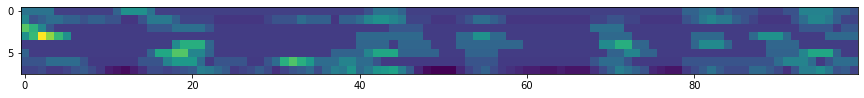

In [9]:
# first 10 seconds
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.imshow(unit_act_matrix[:, 0:100])

In [10]:
hw = 7   # secs
psth_matrix  = np.zeros([len(tgt_matrix), 2*int(hw/step)])

for i, tgt_record in enumerate(tgt_matrix):
    am_idx = int(tgt_record[0]*step)
    pop_response = unit_act_matrix[:, am_idx - int(hw/step):am_idx + int(hw/step)].sum(axis=0)
    if len(pop_response) == psth_matrix.shape[1]:
        psth_matrix[i] = pop_response

In [19]:
# separate by behav fit
# moseq_file = os.path.join(source, animal, session, 'moseq.h5')
# with h5py.File(moseq_file, 'r') as f:
#     behav_fit_AL = np.array(f['behav_fit_AL'])
    
# behav_fit_AL[:, 1] = stats.zscore(behav_fit_AL[:, 1])
# idxs_behav_fit = [np.abs(behav_fit_AL[:, 0] - r[0]).argmin() for r in tgt_matrix]
# idxs_high = np.where(behav_fit_AL[idxs_behav_fit][:, 1] > 0)[0]
# idxs_low  = np.where(behav_fit_AL[idxs_behav_fit][:, 1] < 0)[0]

# separate y success / miss
idxs_high = np.where(tgt_matrix[:, 4] == 1)[0]
idxs_low  = np.where(tgt_matrix[:, 4] == 0)[0]

# separate by AEPs metrics (first TGT pulse)
#area, metric = 'A1', 'P1'
#AEP_metrics_norm[area][metric]

weights_all  = psth_matrix.sum(axis=0)
weights_high = psth_matrix[idxs_high].sum(axis=0) / len(idxs_high)
weights_low  = psth_matrix[idxs_low].sum(axis=0) / len(idxs_low)

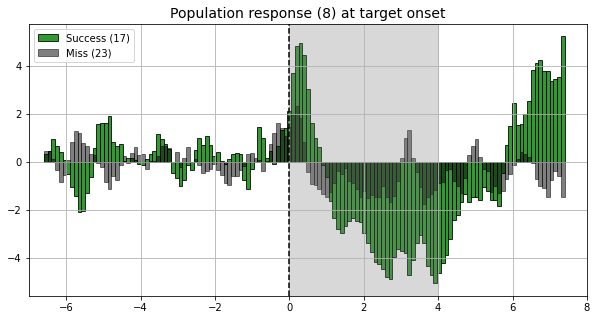

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

tgt_dur = cfg['experiment']['target_duration']
bins = np.linspace(-7 + bin_size, 7 + bin_size, psth_matrix.shape[1])
ax.hist(bins, bins=bins, weights=weights_high, edgecolor='black', color='green', alpha=0.8, label='Success (%d)' % len(idxs_high))
ax.hist(bins, bins=bins, weights=weights_low, edgecolor='black', color='black', alpha=0.5, label='Miss (%d)' % len(idxs_low))
ax.axvline(0, color='black', ls='--')
ax.set_title("Population response (%d) at target onset" % len(tgt_units), fontsize=14)
ax.grid()
ax.set_xlim(-hw, hw + 1)
ax.legend(loc='upper left')
ax.axvspan(0, tgt_dur, alpha=0.3, color='gray')

In [13]:
tgt_units

['2-11', '2-12', '2-2', '2-4', '2-5', '2-6', '2-7', '2-9']

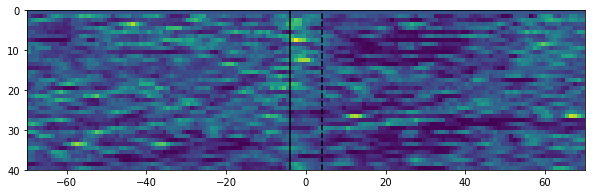

In [14]:
idx_l, idx_r = int(hw/step) - int(bin_size/step), int(hw/step) + int(bin_size/step)
pop_response = psth_matrix[:, idx_l:idx_r].sum(axis=1)

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.imshow(psth_matrix, extent=[-70, 70, len(tgt_matrix), 0])
ax.axvline(-70 + idx_l, color='black')
ax.axvline(-70 + idx_r, color='black', ls='--')

(0.31140837257396103, 0.05046414686670514)


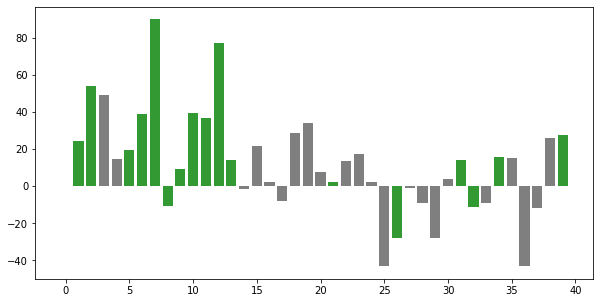

In [15]:
idxs_succ = np.where(tgt_matrix[:, 4] == 1)[0]
idxs_miss = np.where(tgt_matrix[:, 4] == 0)[0]

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.bar(idxs_succ, pop_response[idxs_succ], width=0.8, color='green', alpha=0.8)
ax.bar(idxs_miss, pop_response[idxs_miss], width=0.8, color='black', alpha=0.5)

print(stats.pearsonr(pop_response > pop_response.mean(), tgt_matrix[:, 4]))

In [16]:
area = 'A1'
for offset in np.arange(8) - 2:
    print(offset)
    for name, metric in AEP_metrics_norm[area].items():
        cf, pval = stats.pearsonr(metric[tgt_matrix[:, 2] + offset], pop_response)
        #clr = '\033[92m' if pval < 0.05 else ''
        is_sign = '!!!' if pval < 0.05 else ''
        print("%s: %.3f \t%.3f %s" % (name, cf, pval, is_sign))

-2
N1: 0.237 	0.141 
P1: 0.160 	0.325 
P2: 0.190 	0.240 
P3: 0.036 	0.827 
-1
N1: 0.216 	0.180 
P1: 0.101 	0.536 
P2: 0.189 	0.242 
P3: -0.031 	0.850 
0
N1: 0.163 	0.315 
P1: 0.032 	0.844 
P2: 0.155 	0.338 
P3: -0.089 	0.587 
1
N1: 0.105 	0.520 
P1: -0.043 	0.793 
P2: 0.098 	0.548 
P3: -0.121 	0.456 
2
N1: 0.059 	0.718 
P1: -0.120 	0.461 
P2: 0.034 	0.836 
P3: -0.127 	0.434 
3
N1: 0.026 	0.873 
P1: -0.193 	0.233 
P2: -0.033 	0.839 
P3: -0.118 	0.468 
4
N1: 0.003 	0.985 
P1: -0.256 	0.110 
P2: -0.100 	0.541 
P3: -0.119 	0.463 
5
N1: -0.009 	0.958 
P1: -0.306 	0.055 
P2: -0.153 	0.346 
P3: -0.144 	0.374 
